# Linear Prediction Coefficient

### Introduction

Linear Predictive Coding(LPC) provides an accurate and economical representation of relevant speech parameters that can reduce transmission rates in speech coding, increase accuracy and reduce calculation in speech recognition, and generate efficient speech synthesis. 

The basic idea behind LPC is that a speech sample can be approximated as a linear combination of past speech samples. By minimizing the sum of squared differences over a finite interval between actual speech samples and the linearly predicted ones, a unique set of predictor coefficients can be determined.

### Steps for LPC Computation
![](images/LPC_Block_Diagram.png)

### Setup

We first need to import the required Python libraries for the entire anaylsis  
Prerequisites required in this implementation are:
```
Python 3.x 
numpy   
scipy
librosa
```

You can invoke any required library into your workspace as:  
`import package_name`  

In [1]:
%matplotlib inline
import librosa
import IPython
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.linalg import solve_toeplitz

Reading the file name, and setting the order of the LPC model as 13

In [2]:
filename = "audio_files/Kshama.wav"
sample_rate, signal = wav.read(filename)
order = 13

Lets listen to the audio file

In [3]:
IPython.display.Audio(filename)

### Preprocessing
Applying pre-emphasis and windowing

In [4]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
frame_size = 0.025 
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
frames *= np.blackman(frame_length)

Lets plot the first frame

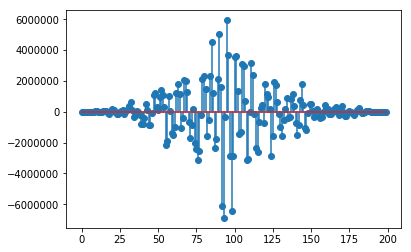

In [5]:
plt.stem(frames[0],use_line_collection=True)
plt.show()

### Computing LPC for 1 frame
Using Autocorrelation method to generate a toeplitz matrix and solving it using Levsion-Durbin Recursion

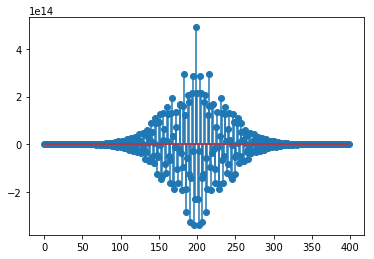

In [6]:
# Computing autocorrelation of the frame
autocorrelation = sig.correlate(frames[0], frames[0])

plt.stem(autocorrelation, use_line_collection=True)
plt.show()

Since autocorrelation is symmteric about zero, we only select the portion with positive lag

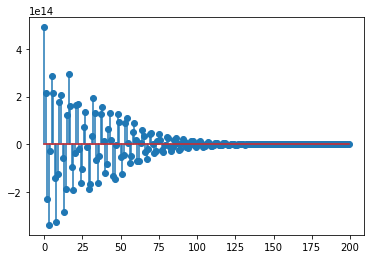

In [8]:
autocorr_coefficients = autocorrelation[int(len(autocorrelation)/2):]
plt.stem(autocorr_coefficients, use_line_collection=True)
plt.show()

Feeding the autocorrelation coefficients to scipy's solve_toeplitz function ([documentation](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.linalg.solve_toeplitz.html))

In [9]:
lpc_coefficients = -1*solve_toeplitz(autocorr_coefficients[:order],autocorr_coefficients[1:order+1])
print(lpc_coefficients)

[-0.72659834  0.6395987   0.13407835  0.07133818 -0.11240253  0.13059597
  0.23777151  0.02950588  0.02999637  0.19218989  0.25486624 -0.09804552
  0.33377161]


We computed LPC coefficients using librosa library to verify our results

In [10]:
lpc_librosa = librosa.lpc(frames[0],order=13)[1:]
print(lpc_librosa)

[-0.72659699  0.63959896  0.13407913  0.07133893 -0.11240178  0.13059642
  0.23777151  0.02950683  0.02999668  0.19218957  0.25487065 -0.09804876
  0.33377556]


Making this whole flow into a function

In [14]:
def compute_lpc_coeff(filename, order=13, write_file = False):
    sample_rate, signal = wav.read(filename)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025 
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.blackman(frame_length)
    lpc_coefficients = np.zeros((num_frames,order))
    lpc_librosa = np.zeros((num_frames,order))
    
    for i in range(0,len(frames),1):
        autocorrelation = sig.correlate(frames[0], frames[0])
        autocorr_coefficients = autocorrelation[int(len(autocorrelation)/2):]
        lpc_coefficients[i] = solve_toeplitz(autocorr_coefficients[:order],autocorr_coefficients[1:order+1])
        lpc_coefficients[i]*= -1
        
        lpc_librosa[i] = librosa.lpc(frames[i],order)[1:]
        
    error = np.sum(np.abs(lpc_librosa - lpc_coefficients)**2)
    print("Error per frame = ", error/num_frames)
    
    if write_file:
        np.savetxt("LPC_coeff.txt",lpc_coefficients)
        
    return lpc_coefficients

In [15]:
lpc_coeff = compute_lpc_coeff("audio_files/Kshama.wav", 13, True)

Error per frame =  1.924296809034811
